In [1]:
import warnings;
warnings.filterwarnings('ignore');

# RDS Decoding

### Tuning to an FM channel


In [2]:
import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt
from matplotlib import gridspec
from scipy.io import wavfile

fs, data = wavfile.read('SDRSharp_20190403_003831Z_91600000Hz_IQ.wav', mmap=True)
wo = 2*np.pi*-100000/fs
svnn1 = 'RDS_sample_915.txt'
svnn2 = 'RDS_sample_915.png'

# Complex IQ representation of the data
IQ = data[:,0] + 1j*data[:,1]

# low pass filter for the FM channel bandwidth
channelFilt = signal.remez(50, [0, 200000, 300000, fs/2], [1,0], fs=fs)

# Demodulate the channel to baseband, then filter 
IQ = IQ*np.exp(-1j*wo*np.arange(IQ.shape[0]))
IQ = signal.convolve(IQ, channelFilt, mode='valid')

# Plot the spectrum of the FM channel
plt.figure(figsize= (8,4))
plt.psd(IQ, Fs=fs, NFFT = 1024)
plt.show()


<Figure size 800x400 with 1 Axes>

### Demodulating the FM signal

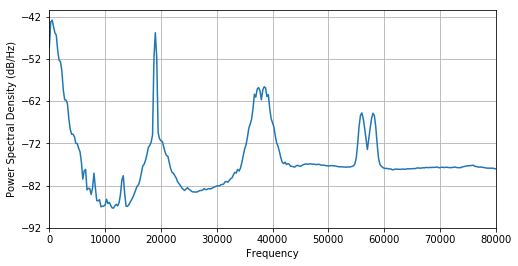

In [3]:
# Decimate to reduce the sample rate from 1.024 Msps to 256 ksps
fsM = 256000
IQ = signal.decimate(IQ, int(fs/fsM))

# FM demodulation in one line 
MPX_FM = np.angle([x[0]*np.conj(x[1]) for x in zip(IQ[1:], IQ[:-1])])

# Plot the multiplex spectrum of the FM channel
plt.figure(figsize= (8,4))
plt.psd(MPX_FM, Fs=fsM, NFFT=1024)
plt.xlim([0, 80000])
plt.show()

### Isolating the RDS signal

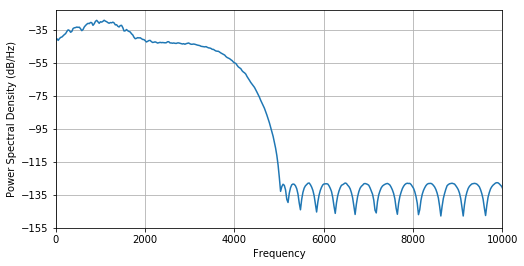

In [4]:
# low pass filter for the RDS subcarrier
RDSFilt = signal.remez(500, [0, 2400, 5000, fsM/2], [1,0], fs=fsM)

# Bring the RDS subcarrier to baseband and flter out the audio signals
wo = 2*np.pi*57000/fsM
RDS = MPX_FM*np.cos(wo*np.arange(MPX_FM.shape[0]))
RDS = 10*signal.convolve(RDS, RDSFilt, mode='valid')

# Reduce the sample rate to 57ksps by resampling.
# This is desirable since 57kHz is an integer multiple of the RDS symbol rate (48*1187.5 sps).
# The decimation factor used here is 4.5, so the actual obtained sample rate is 56.89ksps.
# This frequency error will be taken care of in the carrier phase and symbol timing recovery stages.
RDS = signal.resample_poly(RDS, 2, 9)*10
fsR = 57000 # new sample frequency

# normalize
RDS = RDS/np.sqrt(np.mean(np.abs(RDS)**2))


# Plot the baseband RDS spectrum
plt.figure(figsize= (8,4))
plt.psd(RDS, Fs=fsR, NFFT=2048)
plt.xlim([0,10000])
plt.show()


### Carrier Phase Recovery

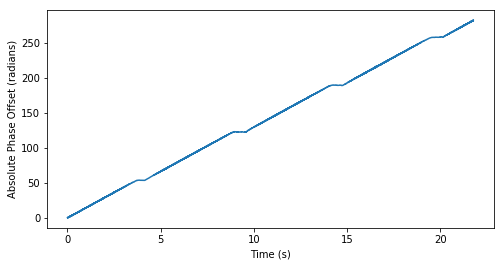

In [5]:
# This is a Costas loop implementation based on the Matlab code provided in 
# Telecommunication Breakdown, by C. Richard Johnson Jr. and William A. Sethares.

# Set up parameters for the carrier phase recovery loop
wc = 2*np.pi*1187.5/fsR   # expected carrier frequency
mu = 0.005                 # update weight (determines loop bandwidth)

nn = np.arange(len(RDS))  
theta = np.zeros(len(nn)) # array for storing carrier phase offset

flen = 48                 # loop filter length
zs = np.zeros((flen,))    # preallocate array for use in loop
zc = np.zeros((flen,))
# create the loop filter (low-pass filter)
loop_filt = signal.remez(flen, [0, 500, 1000, fsR/2], [1, 0], fs = fsR)

# loop through the sample values computing the phase offset at each step
for k in range(len(nn)-1):
    zs = np.append(zs[1:], 2*RDS[k]*np.sin(wc*nn[k] + theta[k]))
    zc = np.append(zc[1:], 2*RDS[k]*np.cos(wc*nn[k] + theta[k]))
    lpfs = np.dot(loop_filt, zs)
    lpfc = np.dot(loop_filt, zc)
    theta[k+1] = theta[k] - mu*lpfs*lpfc

# plot the obtained carrier phase
plt.figure(figsize=(8,4))
plt.plot(np.arange(len(theta))/fsR, theta)
plt.ylabel('Absolute Phase Offset (radians)')
plt.xlabel('Time (s)')
plt.show()

basefilt0 = signal.remez(96, [0, 400, 1500, fsR/2], [1, 0], fs = fsR)

# Apply the phase correction and then demodulate the BPSK signal
phase_correct = np.exp(1j*theta)
RDS_demod = RDS*np.exp(1j*wc*nn)*phase_correct
RDS_demod = signal.lfilter(basefilt0, 1.0, RDS_demod)

# Also demodulate without phase correction so we can compare the performance
RDS_demod_nophase = RDS*np.exp(1j*wc*nn)
RDS_demod_nophase = signal.lfilter(basefilt0, 1.0, RDS_demod_nophase)



### Symbol Timing Recovery

In [10]:
# number of symbols to include in each timing recovery block
block_N = 26

# preallocate space for the samples
RDS_sampled = np.zeros((int(RDS_demod.shape[0]/48),), dtype=complex)
RDS_sa_nophase = np.zeros((int(RDS_demod.shape[0]/48),), dtype=complex)
all_sample_locations = np.array([])

# loop through the signal
for ii in range(int(RDS_demod.shape[0]/(block_N*48) - 1)):
    # get a chunk of length 48*block_N
    chunk = RDS_demod[ii*(block_N*48):(ii+1)*(block_N*48)]
    chunk_np = RDS_demod_nophase[ii*(block_N*48):(ii+1)*(block_N*48)]
    
    # create a 'comb' to pick out sample values
    sample_locations = np.zeros(chunk.shape)
    sample_locations[0:-1:48] = 1
    signal_power = np.zeros((48,))
    
    # determine the total signal power for each sampling offset
    for kk in range(48):
        xx = np.roll(sample_locations, kk)>0
        sa = np.real(chunk[xx])
        power = np.sum(sa**2)
        signal_power[kk] = power
    
    # fild the offset which maximizes the output power
    optimal_offset = np.argmax(signal_power)
    optimal_samples = np.roll(sample_locations, optimal_offset).astype(bool)
    
    # save the optimal samples
    RDS_sampled[ii*block_N:(ii+1)*block_N] = chunk[optimal_samples]
    RDS_sa_nophase[ii*block_N:(ii+1)*block_N] = chunk_np[optimal_samples]
    all_sample_locations = np.concatenate((all_sample_locations, optimal_samples))

# Slicer: convert sample values to zeros and ones
RDS_bitstream = (np.sign(np.real(RDS_sampled))).astype(int)
RDS_bitstream[RDS_bitstream == -1] = 0

RDS_sa_nosync = RDS_demod[::48]
RDS_sa_nophase_nosync = RDS_demod_nophase[::48]

### Creating a Constellation Diagram

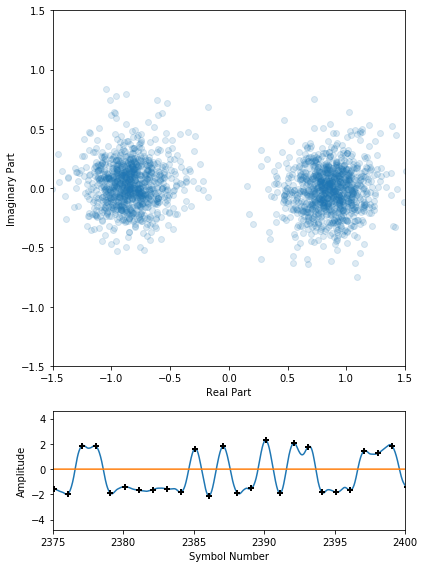

In [11]:
nn = np.arange(RDS.shape[0])

fig = plt.figure(figsize=(6, 8))
gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1])

# plot the constellation diagram
ax0 = plt.subplot(gs[0])
plt.scatter(np.real(RDS_sampled[6000:8000]), np.imag(RDS_sampled[6000:8000]), alpha=0.15)
plt.ylim([-1.5, 1.5])
plt.xlim([-1.5, 1.5])
plt.xlabel('Real Part')
plt.ylabel('Imaginary Part')

# also plot a section of the output waveform and its sample locations.
ax1 = plt.subplot(gs[1])
plt.plot(nn/48, np.real(RDS_demod)*2)
plt.plot(nn/48, np.zeros(nn.shape))

sample_t = np.arange(all_sample_locations.shape[0])
sample_t = sample_t[all_sample_locations.astype(bool)]

plt.plot(sample_t/48 , 2*RDS_sampled[0:sample_t.shape[0]], 'k+', mew = 2)
plt.xlim([114000/48, 115200/48])
plt.xlabel('Symbol Number')
plt.ylabel('Amplitude')

plt.tight_layout()
plt.show()

### Comparing the output with and without carrier phase recovery and symbol timing recovery

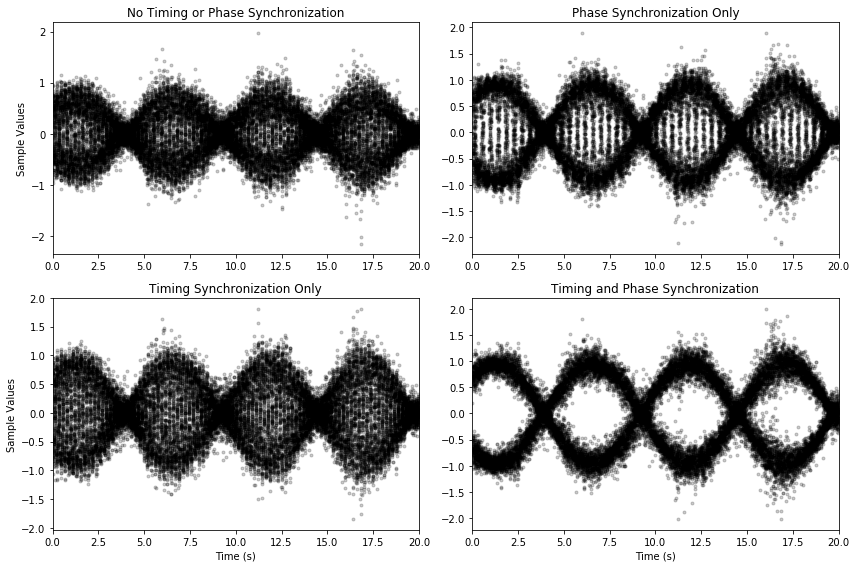

In [12]:
'''Plot the real part of the constellation diagram over time in order to compare 
the output with and without carrier phase and symbol timing recovery '''

ns = np.arange(RDS_sampled.shape[0])

fig = plt.figure(figsize=(12, 8))
gs = gridspec.GridSpec(2, 2, height_ratios=[1, 1])

plt.subplot(gs[0])
plt.plot(ns.astype(float)/1187.5, RDS_sa_nophase_nosync[:-1], 'k.', alpha = 0.2)
plt.ylabel('Sample Values')
plt.title('No Timing or Phase Synchronization')
plt.xlim([0,20])

plt.subplot(gs[1])
plt.plot(ns.astype(float)/1187.5, RDS_sa_nosync[:-1], 'k.', alpha = 0.2)
plt.title('Phase Synchronization Only')
plt.xlim([0,20])

plt.subplot(gs[2])
plt.plot(ns.astype(float)/1187.5, RDS_sa_nophase, 'k.', alpha = 0.2)
plt.xlabel('Time (s)')
plt.ylabel('Sample Values')
plt.title('Timing Synchronization Only')
plt.xlim([0,20])

plt.subplot(gs[3])
plt.plot(ns.astype(float)/1187.5, RDS_sampled, 'k.', alpha = 0.2)
plt.xlabel('Time (s)')
plt.title('Timing and Phase Synchronization')
plt.xlim([0,20])

plt.tight_layout()
plt.show()

### Decoding the received bitstream

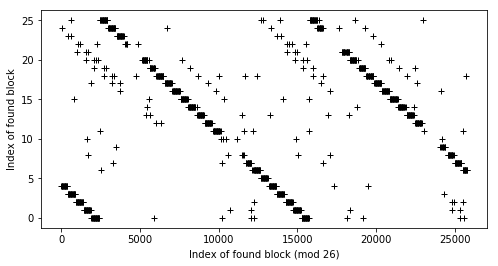

In [13]:
# Turn back now if using numpy arrays to do bitwise operations upsets you.

# differential decoding
RDS_bits = np.bitwise_xor(RDS_bitstream[1:], RDS_bitstream[:-1],)

# syndromes corresponding to valid block types (see IEC 62106 p.xx)
checkw = np.array([[1,1,1,1,0,1,1,0,0,0],
                  [1,1,1,1,0,1,0,1,0,0],
                  [1,0,0,1,0,1,1,1,0,0],
                  [1,1,1,1,0,0,1,1,0,0],
                  [1,0,0,1,0,1,1,0,0,0]])

# names associated with each group type
mtypes = ['A', 'B', 'C', 'D','Cp'] 

# create the parity check matrix H as specified in IEC 62106 p.xx        
h1 = np.array([[1,0,1,1,0,1,1,1,0,0],
      [0,1,0,1,1,0,1,1,1,0],
      [0,0,1,0,1,1,0,1,1,1],
      [1,0,1,0,0,0,0,1,1,1],
      [1,1,1,0,0,1,1,1,1,1],
      [1,1,0,0,0,1,0,0,1,1],
      [1,1,0,1,0,1,0,1,0,1],
      [1,1,0,1,1,1,0,1,1,0],
      [0,1,1,0,1,1,1,0,1,1],
      [1,0,0,0,0,0,0,0,0,1],
      [1,1,1,1,0,1,1,1,0,0],
      [0,1,1,1,1,0,1,1,1,0],
      [0,0,1,1,1,1,0,1,1,1],
      [1,0,1,0,1,0,0,1,1,1],
      [1,1,1,0,0,0,1,1,1,1],
      [1,1,0,0,0,1,1,0,1,1]])
H = np.concatenate((np.eye(10), h1), axis=0)

block_offsets = []
HHDD = np.zeros((5,RDS_bits.shape[0]- 26 ))


# Find all blocks with valid checkwords
for j in range(RDS_bits.shape[0]- 26):
    y = RDS_bits[j:j+26] 
    cw = np.mod(y.T@H, 2*np.ones((10,)))
    
    # Check if the computed checkword offset corresponds to one of the valid block types.
    for k in range(5):
        hammingdist = np.count_nonzero(cw-checkw[k,:])
        if np.count_nonzero(hammingdist) == 0:
            block_offsets.append(j)

hitindex = [h % 26 for h in block_offsets]

# plot the index (mod 26) where each successful block is detected. 
# RDS is a continuous-transfer protocol so ideally this should be a horizontal line.
# Unfortunately this step shows that there is a lot of timing drift

plt.figure(figsize=(8,4))
plt.plot(block_offsets, hitindex, 'k+')
plt.xlabel('Block index (mod 26)')
plt.ylabel('Block index')
plt.show()

